# Boston Bluebikes data
## by Torben Flickinger

## Preliminary Wrangling

> Bluebikes is Metro Boston's public bike share program, with more than 1,800 bikes at over 200 stations across Boston, Brookline, Cambridge and Somerville. Bluebikes is owned by the municipalities of Boston, Brookline, Cambridge and Somerville, and operated by Motivate. Bluebikes publishes trip data regularly on https://www.bluebikes.com/system-data . For my analysis I downloaded the trip data for all months of 2019. 
To be able to investigate possible relationships of the use of this service to weather data, I additionally downloaded a dataset with historical weather data for Boston from the National Oceanic and athmospheric Administration https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00014739/detail.

#### Importing the libraries

In [199]:
import numpy as np
from bs4 import BeautifulSoup
import os

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)

import re # library for regular expressions
import zipfile

#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#from geopy.geocoders import ArcGIS # convert an address into latitude and longitude values
from geopy.distance import distance

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import seaborn as sns
plt.style.use('fivethirtyeight')

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Data Gathering

#### 1. Trip data
Getting the trip data from https://www.bluebikes.com/system-data.
First defining some helper functions to search the online file archive for downloadable files for the required year (2019 in our case).
Since the trip data are zip archives, we have to extract them before loading them into our notebook.  
We'll first load the zip file to the project folder `./data/Boston` and then unzip the files to `./data/Boston/csv`.

In [200]:
# defining our local data folders
ZIPLOC = "./data/Boston"
CSVLOC = "./data/Boston/csv"
boston_weather_data = "./data/weather_data_boston.csv"

#defining helper functions for downloading and unzipping the trip data
def download_trip_data(year=2019):
    url = 'https://s3.amazonaws.com/hubway-data/'
    website_url = requests.get(url).text
    strYear=str(year)
    soup = BeautifulSoup(website_url,'html.parser')
    year_pattern = re.compile(strYear + '\d{2}')
    for key in soup.find_all('key'):
        if year_pattern.match(key.text):
            print(key.text)
            url_file = url + key.text
            #print(url_file)
            if  not (os.path.exists(ZIPLOC + '/' + key.text)):
                print("downloading " + url_file)
                r = requests.get(url_file)
                print(r)
                with open(ZIPLOC + '/' + key.text, 'wb') as f:
                    f.write(r.content)
            else:
                print("file already downloaded")

def unzip_files(from_dir, to_dir):
    for item in os.listdir(from_dir):
        if item.endswith('zip'):
            if os.path.exists(CSVLOC + '/' + os.path.splitext(item)[0]):
                print(os.path.splitext(item)[0] + " already exists.")
            else:
                print('unzipping ' + item)
                with zipfile.ZipFile(from_dir + '/' + item, 'r') as zip_ref:
                    zip_ref.extractall(to_dir)
    

In [201]:
# downloading files
download_trip_data(year=2019)

201901-bluebikes-tripdata.zip
file already downloaded
201902-bluebikes-tripdata.zip
file already downloaded
201903-bluebikes-tripdata.zip
file already downloaded
201904-bluebikes-tripdata.zip
file already downloaded
201905-bluebikes-tripdata.zip
file already downloaded
201906-bluebikes-tripdata.zip
file already downloaded
201907-bluebikes-tripdata.zip
file already downloaded
201908-bluebikes-tripdata.zip
file already downloaded
201909-bluebikes-tripdata.zip
file already downloaded
201910-bluebikes-tripdata.zip
file already downloaded
201911-bluebikes-tripdata.zip
file already downloaded
201912-bluebikes-tripdata.zip
file already downloaded


In [202]:
# unzip files
unzip_files(ZIPLOC, CSVLOC)

unzipping 201901-bluebikes-tripdata.zip
unzipping 201902-bluebikes-tripdata.zip
unzipping 201903-bluebikes-tripdata.zip
unzipping 201904-bluebikes-tripdata.zip
unzipping 201905-bluebikes-tripdata.zip
unzipping 201906-bluebikes-tripdata.zip
201907-bluebikes-tripdata already exists.
201908-bluebikes-tripdata already exists.
unzipping 201909-bluebikes-tripdata.zip
unzipping 201910-bluebikes-tripdata.zip
unzipping 201911-bluebikes-tripdata.zip
unzipping 201912-bluebikes-tripdata.zip


#### Setting up a data frame and load the trip data into it:

In [203]:
df_bike_data = pd.DataFrame()
for item in os.listdir(CSVLOC):
    if os.path.isfile(CSVLOC + '/' + item):
        df_bike_data = pd.concat([df_bike_data,pd.read_csv(CSVLOC + '/' + item)])
        print("added "+ CSVLOC + "/" + item + " to data frame.")
    else:
        print(item + " is no file")
print("resetting index ...")
df_bike_data = df_bike_data.reset_index()
df_bike_data.head()

added ./data/Boston/csv/201901-bluebikes-tripdata.csv to data frame.
added ./data/Boston/csv/201902-bluebikes-tripdata.csv to data frame.
added ./data/Boston/csv/201903-bluebikes-tripdata.csv to data frame.
added ./data/Boston/csv/201904-bluebikes-tripdata.csv to data frame.
added ./data/Boston/csv/201905-bluebikes-tripdata.csv to data frame.
added ./data/Boston/csv/201907-bluebikes-tripdata to data frame.
added ./data/Boston/csv/201907-bluebikes.tripdata.csv to data frame.
added ./data/Boston/csv/201908-bluebikes-tripdata to data frame.
added ./data/Boston/csv/201909-bluebikes-tripdata.csv to data frame.
added ./data/Boston/csv/201910-bluebikes-tripdata.csv to data frame.
added ./data/Boston/csv/201911-bluebikes-tripdata.csv to data frame.
added ./data/Boston/csv/201912-bluebikes-tripdata.csv to data frame.
added ./data/Boston/csv/readme.txt to data frame.
__MACOSX is no file
resetting index ...


,index,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,Folder for extracting the csv files from the zip archives in the parent folder
0,0,371.0,2019-01-01 00:09:13.7980,2019-01-01 00:15:25.3360,80.0,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179.0,MIT Vassar St,42.355601,-71.103945,3689.0,Subscriber,1987.0,1.0,NaN
1,1,264.0,2019-01-01 00:33:56.1820,2019-01-01 00:38:20.8800,117.0,Binney St / Sixth St,42.366162,-71.086883,189.0,Kendall T,42.362428,-71.084955,4142.0,Subscriber,1990.0,1.0,NaN
2,2,458.0,2019-01-01 00:41:54.6000,2019-01-01 00:49:33.2730,68.0,Central Square at Mass Ave / Essex St,42.365070,-71.103100,96.0,Cambridge Main Library at Broadway / Trowbridg...,42.373379,-71.111075,1628.0,Subscriber,1977.0,1.0,NaN
3,3,364.0,2019-01-01 00:43:32.5710,2019-01-01 00:49:37.4260,89.0,Harvard Law School at Mass Ave / Jarvis St,42.379011,-71.119945,334.0,Mass Ave at Hadley/Walden,42.391210,-71.122608,2969.0,Subscriber,1993.0,1.0,NaN
4,4,681.0,2019-01-01 00:49:56.4640,2019-01-01 01:01:17.7010,73.0,Harvard Square at Brattle St / Eliot St,42.373231,-71.120886,367.0,Vassal Lane at Tobin/VLUS,42.383932,-71.139613,3469.0,Subscriber,1979.0,2.0,NaN


In [204]:
df_bike_data.shape

(2522537, 17)

In [205]:
df_bike_data.dtypes

index                                                                               int64
tripduration                                                                      float64
starttime                                                                          object
stoptime                                                                           object
start station id                                                                  float64
start station name                                                                 object
start station latitude                                                            float64
start station longitude                                                           float64
end station id                                                                    float64
end station name                                                                   object
end station latitude                                                              float64
end statio

In [206]:
# checking for null values
df_bike_data.isnull().sum()

index                                                                                   0
tripduration                                                                            0
starttime                                                                               0
stoptime                                                                                0
start station id                                                                        0
start station name                                                                      0
start station latitude                                                                  0
start station longitude                                                                 0
end station id                                                                          0
end station name                                                                        0
end station latitude                                                                    0
end statio

> no null values, indicating that imputing might not be necessary

In [207]:
df_bike_data.bikeid.unique().size

4652

In [208]:
df_bike_data.head(1).T

,0
index,0
tripduration,371
starttime,2019-01-01 00:09:13.7980
stoptime,2019-01-01 00:15:25.3360
start station id,80
start station name,MIT Stata Center at Vassar St / Main St
start station latitude,42.3621
start station longitude,-71.0912
end station id,179
end station name,MIT Vassar St


#### 2. Boston Historical Weather Data
First I downloaded the weather data from https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00014739/detail.

Now loading the data into a pandas data frame:

In [209]:
df_weather = pd.read_csv(boston_weather_data)
df_weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,AWND_ATTRIBUTES,PGTM,PGTM_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,WDF2,WDF2_ATTRIBUTES,WDF5,WDF5_ATTRIBUTES,WSF2,WSF2_ATTRIBUTES,WSF5,WSF5_ATTRIBUTES,WT01,WT01_ATTRIBUTES,WT02,WT02_ATTRIBUTES,WT03,WT03_ATTRIBUTES,WT04,WT04_ATTRIBUTES,WT05,WT05_ATTRIBUTES,WT06,WT06_ATTRIBUTES,WT08,WT08_ATTRIBUTES,WT09,WT09_ATTRIBUTES
0,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,2019-01-01,7.1,",,W",NaN,NaN,9.7,",,W,2400",0.0,",,W",NaN,NaN,8.4,"H,,S",15.0,",,W",1.1,",,W",290.0,",,W",290.0,",,W",15.7,",,W",21.0,",,W",1.0,",,W",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,2019-01-02,4.2,",,W",NaN,NaN,0.0,",,W,2400",0.0,",,W",NaN,NaN,0.8,"H,,S",2.8,",,W",-2.1,",,W",310.0,",,W",330.0,",,W",8.1,",,W",10.3,",,W",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,2019-01-03,4.7,",,W",NaN,NaN,0.5,",,W,2400",0.0,"T,,W",NaN,NaN,3.1,"H,,S",7.8,",,W",0.0,",,W",320.0,",,W",320.0,",,W",8.9,",,W",12.1,",,W",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,2019-01-04,5.0,",,W",NaN,NaN,0.0,",,W,2400",0.0,",,W",NaN,NaN,4.6,"H,,S",8.9,",,W",1.1,",,W",230.0,",,W",220.0,",,W",10.7,",,W",13.4,",,W",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,2019-01-05,4.1,",,W",NaN,NaN,13.5,",,W,2400",0.0,",,W",NaN,NaN,5.0,"H,,S",6.1,",,W",3.3,",,W",360.0,",,W",360.0,",,W",8.1,",,W",9.8,",,W",1.0,",,W",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [210]:
df_weather.shape

(401, 46)

In [211]:
df_weather.isnull().sum()

STATION              0
NAME                 0
LATITUDE             0
LONGITUDE            0
ELEVATION            0
DATE                 0
AWND                 1
AWND_ATTRIBUTES      1
PGTM               400
PGTM_ATTRIBUTES    400
PRCP                 0
PRCP_ATTRIBUTES      0
SNOW                 0
SNOW_ATTRIBUTES      0
SNWD               400
SNWD_ATTRIBUTES    400
TAVG                 0
TAVG_ATTRIBUTES      0
TMAX                 0
TMAX_ATTRIBUTES      0
TMIN                 0
TMIN_ATTRIBUTES      0
WDF2                 1
WDF2_ATTRIBUTES      1
WDF5                 1
WDF5_ATTRIBUTES      1
WSF2                 1
WSF2_ATTRIBUTES      1
WSF5                 1
WSF5_ATTRIBUTES      1
WT01               252
WT01_ATTRIBUTES    252
WT02               380
WT02_ATTRIBUTES    380
WT03               378
WT03_ATTRIBUTES    378
WT04               394
WT04_ATTRIBUTES    394
WT05               399
WT05_ATTRIBUTES    399
WT06               395
WT06_ATTRIBUTES    395
WT08               346
WT08_ATTRIB

In [212]:
df_weather.dtypes

STATION             object
NAME                object
LATITUDE           float64
LONGITUDE          float64
ELEVATION          float64
DATE                object
AWND               float64
AWND_ATTRIBUTES     object
PGTM               float64
PGTM_ATTRIBUTES     object
PRCP               float64
PRCP_ATTRIBUTES     object
SNOW               float64
SNOW_ATTRIBUTES     object
SNWD               float64
SNWD_ATTRIBUTES     object
TAVG               float64
TAVG_ATTRIBUTES     object
TMAX               float64
TMAX_ATTRIBUTES     object
TMIN               float64
TMIN_ATTRIBUTES     object
WDF2               float64
WDF2_ATTRIBUTES     object
WDF5               float64
WDF5_ATTRIBUTES     object
WSF2               float64
WSF2_ATTRIBUTES     object
WSF5               float64
WSF5_ATTRIBUTES     object
WT01               float64
WT01_ATTRIBUTES     object
WT02               float64
WT02_ATTRIBUTES     object
WT03               float64
WT03_ATTRIBUTES     object
WT04               float64
W

### What is the structure of your dataset?

1. **Trip data**: the Blue Bike trip data for 2019 consists of 2,522,537 records for about 4,600 individual bikes with information in  15 columns.
The column names are already self-explanatory in most cases, so we don't need to rename them:

- tripduration - in seconds 
- starttime - 
- stoptime
- start station id - a unique numerical identifier for the station
- start station name
- start station latitude
- start station longitude
- end station id - a unique numerical identifier for the station
- end station name
- end station latitude
- end station longitude
- bikeid - a unique numerical identifier for the station
- usertype - 'Subscriber' or 'Customer' (Bluebikes distinguishes between with Single Trip or Day Pass users ('Customer') and monthly or annual subscribers)
- birth year
- gender - 0=unknown, 1=male, 2=female



2. **Weather Data**: the data comes with several weather attributes per day of measurements.  
These are:

- WSF2 - Fastest 2-minute wind speed
- WSF5 - Fastest 5-second wind speed
- SNOW - Snowfall
- WT03 - Thunder
- WT04 - Ice pellets, sleet, snow pellets, or small hail"
- PRCP - Precipitation
- WT05 - Hail (may include small hail)
- WT06 - Glaze or rime
- WT08 - Smoke or haze
- SNWD - Snow depth
- WT09 - Blowing or drifting snow
- WDF2 - Direction of fastest 2-minute wind
- AWND - Average wind speed
- WDF5 - Direction of fastest 5-second wind
- PGTM - Peak gust time
- WT01 - Fog, ice fog, or freezing fog (may include heavy fog)
- TMAX - Maximum temperature
- WT02 - Heavy fog or heaving freezing fog (not always distinguished from fog)
- TAVG - Average Temperature.
- TMIN - Minimum temperature

### What is/are the main feature(s) of interest in your dataset?

1. **Trip data**: Essentially all of the data's features are of interest for further analysis, so we will keep all the columns and add some calculated columns like `month`, `week`, `day`, `hour`and `age` for convenience in further operations with the data set. 
2. **Weather Data**: We are interested in precipitation and max temperature only. So we will drop most other columns in the next few data wrangling steps.

## Data Wrangling

Before we start our exploratory analysis we need to perform a few measures to make the data a little more "accessible" and more convenient for our work.

#### 1. Trip data

In [213]:
df_bike_data.head()

,index,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,Folder for extracting the csv files from the zip archives in the parent folder
0,0,371.0,2019-01-01 00:09:13.7980,2019-01-01 00:15:25.3360,80.0,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179.0,MIT Vassar St,42.355601,-71.103945,3689.0,Subscriber,1987.0,1.0,NaN
1,1,264.0,2019-01-01 00:33:56.1820,2019-01-01 00:38:20.8800,117.0,Binney St / Sixth St,42.366162,-71.086883,189.0,Kendall T,42.362428,-71.084955,4142.0,Subscriber,1990.0,1.0,NaN
2,2,458.0,2019-01-01 00:41:54.6000,2019-01-01 00:49:33.2730,68.0,Central Square at Mass Ave / Essex St,42.365070,-71.103100,96.0,Cambridge Main Library at Broadway / Trowbridg...,42.373379,-71.111075,1628.0,Subscriber,1977.0,1.0,NaN
3,3,364.0,2019-01-01 00:43:32.5710,2019-01-01 00:49:37.4260,89.0,Harvard Law School at Mass Ave / Jarvis St,42.379011,-71.119945,334.0,Mass Ave at Hadley/Walden,42.391210,-71.122608,2969.0,Subscriber,1993.0,1.0,NaN
4,4,681.0,2019-01-01 00:49:56.4640,2019-01-01 01:01:17.7010,73.0,Harvard Square at Brattle St / Eliot St,42.373231,-71.120886,367.0,Vassal Lane at Tobin/VLUS,42.383932,-71.139613,3469.0,Subscriber,1979.0,2.0,NaN


We need to convert `starttime` and `stoptime` to datetime fields. Additionally I am going to add extra columns for month, week, day, day of week and hour

In [214]:
df_bike_data.starttime = pd.to_datetime(df_bike_data.starttime)
df_bike_data.stoptime = pd.to_datetime(df_bike_data.stoptime)
df_bike_data.dtypes

index                                                                                      int64
tripduration                                                                             float64
starttime                                                                         datetime64[ns]
stoptime                                                                          datetime64[ns]
start station id                                                                         float64
start station name                                                                        object
start station latitude                                                                   float64
start station longitude                                                                  float64
end station id                                                                           float64
end station name                                                                          object
end station latitude          

In [215]:
df_bike_data['month'] = df_bike_data.starttime.dt.month
df_bike_data['date'] = df_bike_data.starttime.dt.date
df_bike_data['day'] =  df_bike_data.starttime.dt.day
df_bike_data['date'] = pd.to_datetime(df_bike_data['date'])
df_bike_data['week'] = df_bike_data.starttime.dt.week
df_bike_data['hour'] = df_bike_data.starttime.dt.hour
df_bike_data['dayofweek'] = df_bike_data.starttime.dt.dayofweek
df_bike_data.head()

,index,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,Folder for extracting the csv files from the zip archives in the parent folder,month,date,day,week,hour,dayofweek
0,0,371.0,2019-01-01 00:09:13.798,2019-01-01 00:15:25.336,80.0,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179.0,MIT Vassar St,42.355601,-71.103945,3689.0,Subscriber,1987.0,1.0,NaN,1,2019-01-01,1,1,0,1
1,1,264.0,2019-01-01 00:33:56.182,2019-01-01 00:38:20.880,117.0,Binney St / Sixth St,42.366162,-71.086883,189.0,Kendall T,42.362428,-71.084955,4142.0,Subscriber,1990.0,1.0,NaN,1,2019-01-01,1,1,0,1
2,2,458.0,2019-01-01 00:41:54.600,2019-01-01 00:49:33.273,68.0,Central Square at Mass Ave / Essex St,42.365070,-71.103100,96.0,Cambridge Main Library at Broadway / Trowbridg...,42.373379,-71.111075,1628.0,Subscriber,1977.0,1.0,NaN,1,2019-01-01,1,1,0,1
3,3,364.0,2019-01-01 00:43:32.571,2019-01-01 00:49:37.426,89.0,Harvard Law School at Mass Ave / Jarvis St,42.379011,-71.119945,334.0,Mass Ave at Hadley/Walden,42.391210,-71.122608,2969.0,Subscriber,1993.0,1.0,NaN,1,2019-01-01,1,1,0,1
4,4,681.0,2019-01-01 00:49:56.464,2019-01-01 01:01:17.701,73.0,Harvard Square at Brattle St / Eliot St,42.373231,-71.120886,367.0,Vassal Lane at Tobin/VLUS,42.383932,-71.139613,3469.0,Subscriber,1979.0,2.0,NaN,1,2019-01-01,1,1,0,1


instead of `birth year` we would like to have an `age` column for further analysis:

In [216]:
df_bike_data['age'] = 2019 - df_bike_data['birth year']
df_bike_data['age'] = df_bike_data['age'].astype(int)
df_bike_data.head()

,index,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,Folder for extracting the csv files from the zip archives in the parent folder,month,date,day,week,hour,dayofweek,age
0,0,371.0,2019-01-01 00:09:13.798,2019-01-01 00:15:25.336,80.0,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179.0,MIT Vassar St,42.355601,-71.103945,3689.0,Subscriber,1987.0,1.0,NaN,1,2019-01-01,1,1,0,1,32
1,1,264.0,2019-01-01 00:33:56.182,2019-01-01 00:38:20.880,117.0,Binney St / Sixth St,42.366162,-71.086883,189.0,Kendall T,42.362428,-71.084955,4142.0,Subscriber,1990.0,1.0,NaN,1,2019-01-01,1,1,0,1,29
2,2,458.0,2019-01-01 00:41:54.600,2019-01-01 00:49:33.273,68.0,Central Square at Mass Ave / Essex St,42.365070,-71.103100,96.0,Cambridge Main Library at Broadway / Trowbridg...,42.373379,-71.111075,1628.0,Subscriber,1977.0,1.0,NaN,1,2019-01-01,1,1,0,1,42
3,3,364.0,2019-01-01 00:43:32.571,2019-01-01 00:49:37.426,89.0,Harvard Law School at Mass Ave / Jarvis St,42.379011,-71.119945,334.0,Mass Ave at Hadley/Walden,42.391210,-71.122608,2969.0,Subscriber,1993.0,1.0,NaN,1,2019-01-01,1,1,0,1,26
4,4,681.0,2019-01-01 00:49:56.464,2019-01-01 01:01:17.701,73.0,Harvard Square at Brattle St / Eliot St,42.373231,-71.120886,367.0,Vassal Lane at Tobin/VLUS,42.383932,-71.139613,3469.0,Subscriber,1979.0,2.0,NaN,1,2019-01-01,1,1,0,1,40


In the next step we will create a new column with the distance between start and end station. We could use the Haversine formula to calculate the distance between the coordinates, but we will utilize one of the distance functions of the `geopy` library instead. To avoid the application of this function to all 2 million lines of the original data frame separately we will try to take advantage of the fact that there are a lot of duplicates of trips betweeen two stations. So we will create a temporary data frame with unique combinations of start and end stations and calculate their distance. Then we will merge the results with our original trip data.

In [217]:
print("creating temporary columns ...")
df_bike_data['tmp_coords'] = df_bike_data[[ 'start station latitude', 'start station longitude','end station latitude', 'end station longitude']].to_numpy().tolist()
# we need a string column as key to join our data frames in the last step and to drop duplicates in the temporary data frame
df_bike_data['tmp_coords_str'] = df_bike_data.tmp_coords.astype(str)

print("creating temporary data frame df_station_dists ...")
df_station_dists=pd.DataFrame()
df_station_dists['locs'] = df_bike_data['tmp_coords']
df_station_dists['str_locs'] = df_bike_data['tmp_coords_str']
unique_index = df_station_dists['str_locs'].astype(str).drop_duplicates().index
df_station_dists = df_station_dists.loc[unique_index]

print('calculating distances ...')
df_station_dists['distance'] = df_station_dists['locs'].apply(lambda x : distance((x[0], x[1]), (x[2], x[3])).m)

print('merging data frames')
df_bike_data = df_bike_data.merge(df_station_dists, left_on='tmp_coords_str', right_on='str_locs')
df_bike_data = df_bike_data.drop(['tmp_coords_str', 'str_locs', 'tmp_coords', 'tmp_coords_str', 'locs'], axis=1)

df_bike_data.head()


creating temporary columns ...
creating temporary data frame df_station_dists ...
calculating distances ...
merging data frames


,index,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,Folder for extracting the csv files from the zip archives in the parent folder,month,date,day,week,hour,dayofweek,age,distance
0,0,371.0,2019-01-01 00:09:13.798,2019-01-01 00:15:25.336,80.0,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179.0,MIT Vassar St,42.355601,-71.103945,3689.0,Subscriber,1987.0,1.0,NaN,1,2019-01-01,1,1,0,1,32,1279.134116
1,6,304.0,2019-01-01 00:54:48.931,2019-01-01 00:59:53.581,80.0,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179.0,MIT Vassar St,42.355601,-71.103945,3861.0,Subscriber,1991.0,1.0,NaN,1,2019-01-01,1,1,0,1,28,1279.134116
2,1111,354.0,2019-01-01 17:54:32.797,2019-01-01 18:00:26.842,80.0,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179.0,MIT Vassar St,42.355601,-71.103945,4053.0,Subscriber,1990.0,1.0,NaN,1,2019-01-01,1,1,17,1,29,1279.134116
3,1114,397.0,2019-01-01 17:57:05.568,2019-01-01 18:03:43.000,80.0,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179.0,MIT Vassar St,42.355601,-71.103945,4160.0,Subscriber,1987.0,1.0,NaN,1,2019-01-01,1,1,17,1,32,1279.134116
4,1140,320.0,2019-01-01 18:33:41.350,2019-01-01 18:39:01.927,80.0,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179.0,MIT Vassar St,42.355601,-71.103945,2893.0,Subscriber,1985.0,1.0,NaN,1,2019-01-01,1,1,18,1,34,1279.134116


## Exploratory Analysis

Let's make a first visualization to get a better grasp of the data:

Text(0.5, 1.0, 'No. of trips by month and user type')

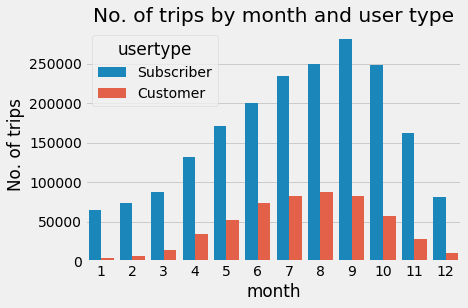

In [218]:
ax =sns.countplot(data=df_bike_data, x='month', hue='usertype')
ax.set_ylabel('No. of trips')
ax.set_title('No. of trips by month and user type')

As we might have expected the usage of the service gradually increases in the course of a year until it reaches a peak in September, when there about five times as many rides as in the winter months. We also realize that the service is mainly used as a subscription service and the usage of user type 'customers' reaches its maximum one month ahead of subscribers in the middle of summer. The latter fact might be a first hint that the user type customer are taking their rides as a recreational activity.

### Checking for outliers and anomalies

#### Trip duration
let's first take a look if we can find some implausible trip durations:

Text(0.5, 0, 'Trip duration (minutes in logarithmic scale)')

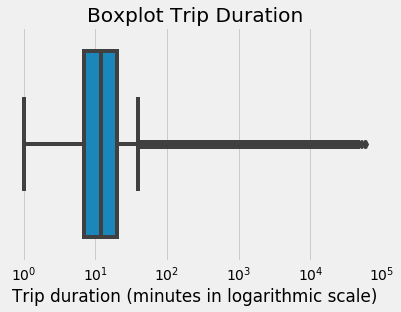

In [220]:
# univariate visualization with logarithmic scale
ax = sns.boxplot(df_bike_data['tripduration'] / 60)
ax.set_title("Boxplot Trip Duration")
ax.set_xscale('log')
ax.set_xlabel('Trip duration (minutes in logarithmic scale)')

As we can see there are a lot of outliers with trip durations of more than 1000 minutes. But generally, the median trip duration of about ten minutes seems absolutely
plausible. Let's explore the distribution of the trip duration in logarithmic scale:

Text(0.5, 1.0, 'Trip duration - distribution in logartithmic scale')

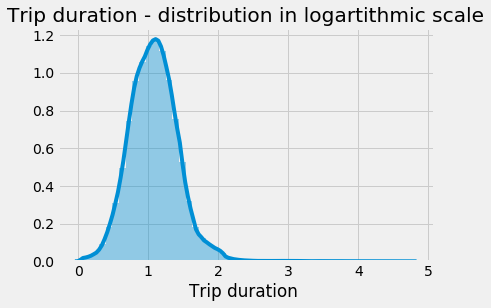

In [221]:
ax = sns.distplot(np.log10(df_bike_data.tripduration / 60), kde=True)
ax.set_xlabel('Trip duration ')
ax.set_title('Trip duration - distribution in logartithmic scale')

The previous figure suggests a lognormal distribution for the trip duration with a median at about 10 minutes.  
Let's see if there are any differences between the two user types subscriber and customer:

In [222]:
# calculating the median programmatically:
df_bike_data['tripduration'].quantile(0.5) / 60

11.783333333333333

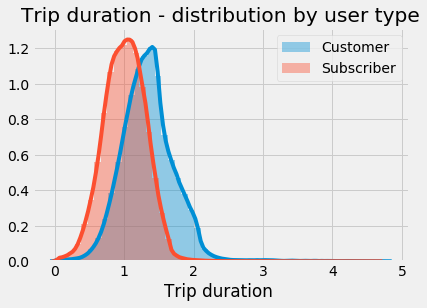

In [223]:
ax = sns.distplot(np.log10(df_bike_data[df_bike_data.usertype == 'Customer'].tripduration / 60), kde=True, label = 'Customer')
ax = sns.distplot(np.log10(df_bike_data[df_bike_data.usertype == 'Subscriber'].tripduration / 60), kde=True, label = 'Subscriber')
ax.set_xlabel('Trip duration ')
ax.legend()
_ = ax.set_title("Trip duration - distribution by user type")

So, the previous figure suggests that Non-Subscribers' trips are slightly longer than those of Subscribers.

#### Trip distance
For a first overview of the trip distances let's try a boxplot of the data:

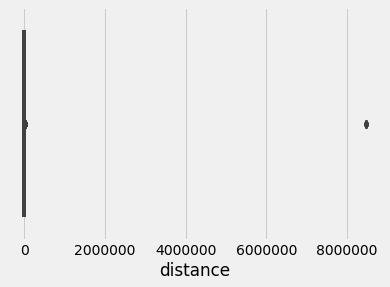

In [224]:
sns.boxplot(df_bike_data['distance'])

Ok, this looks odd. Apparently there are some huge outliers. Let's examine this further by looking at the largest values in the data:

In [225]:
df_bike_data.loc[df_bike_data.distance.nlargest(10).index]

,index,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,Folder for extracting the csv files from the zip archives in the parent folder,month,date,day,week,hour,dayofweek,age,distance
2444884,247583,1041.0,2019-08-23 11:11:38.499,2019-08-23 11:28:59.734,41.0,Packard's Corner - Commonwealth Ave at Brighto...,42.352261,-71.123831,223.0,Warehouse Bonfire Station in a Box,0.000000,0.000000,2498.0,Subscriber,1991.0,1.0,NaN,8,2019-08-23,23,34,11,4,28,8.468497e+06
2444885,247587,1021.0,2019-08-23 11:12:00.621,2019-08-23 11:29:01.919,41.0,Packard's Corner - Commonwealth Ave at Brighto...,42.352261,-71.123831,223.0,Warehouse Bonfire Station in a Box,0.000000,0.000000,2097.0,Subscriber,1992.0,2.0,NaN,8,2019-08-23,23,34,11,4,27,8.468497e+06
2411236,109510,585.0,2019-08-10 14:20:59.192,2019-08-10 14:30:44.938,188.0,Foss Park,42.391084,-71.090394,164.0,Warehouse Lab PBSC,0.000000,0.000000,5412.0,Subscriber,1986.0,2.0,NaN,8,2019-08-10,10,32,14,5,33,8.466770e+06
2444909,247622,838.0,2019-08-23 11:17:31.520,2019-08-23 11:31:29.768,223.0,Warehouse Bonfire Station in a Box,0.000000,0.000000,95.0,Cambridge St - at Columbia St / Webster Ave,42.372969,-71.094445,2551.0,Subscriber,1996.0,2.0,NaN,8,2019-08-23,23,34,11,4,23,8.466648e+06
2444910,247623,830.0,2019-08-23 11:17:41.252,2019-08-23 11:31:32.138,223.0,Warehouse Bonfire Station in a Box,0.000000,0.000000,95.0,Cambridge St - at Columbia St / Webster Ave,42.372969,-71.094445,2083.0,Subscriber,1960.0,2.0,NaN,8,2019-08-23,23,34,11,4,59,8.466648e+06
2444958,247655,377.0,2019-08-23 11:21:50.735,2019-08-23 11:28:08.000,67.0,MIT at Mass Ave / Amherst St,42.358100,-71.093198,223.0,Warehouse Bonfire Station in a Box,0.000000,0.000000,3377.0,Subscriber,1996.0,1.0,NaN,8,2019-08-23,23,34,11,4,23,8.466181e+06
1388670,50153,66.0,2019-01-23 16:44:09.169,2019-01-23 16:45:15.249,229.0,8D QC Station 01,42.345033,-71.096649,230.0,8D QC Station 02,0.000000,0.000000,1583.0,Customer,1969.0,0.0,NaN,1,2019-01-23,23,4,16,2,50,8.466135e+06
2444911,247635,345.0,2019-08-23 11:19:28.341,2019-08-23 11:25:13.411,80.0,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,223.0,Warehouse Bonfire Station in a Box,0.000000,0.000000,3639.0,Subscriber,1986.0,2.0,NaN,8,2019-08-23,23,34,11,4,33,8.466116e+06
2453565,288829,234.0,2019-08-27 11:59:03.154,2019-08-27 12:02:57.473,223.0,Warehouse Bonfire Station in a Box,0.000000,0.000000,279.0,Williams St at Washington St,42.306539,-71.107669,4451.0,Subscriber,1984.0,2.0,NaN,8,2019-08-27,27,35,11,1,35,8.466072e+06
2444801,247467,577.0,2019-08-23 10:54:58.716,2019-08-23 11:04:36.063,189.0,Kendall T,42.362428,-71.084955,223.0,Warehouse Bonfire Station in a Box,0.000000,0.000000,2855.0,Subscriber,1995.0,1.0,NaN,8,2019-08-23,23,34,10,4,24,8.465625e+06


Aaah. So there are several zeros in the geospatial data of some stations. We fix this by replacing the distance column in affected rows with `np.nan`:

In [226]:
df_bike_data.loc[df_bike_data[['start station latitude', 'start station longitude', 'end station latitude', 'end station longitude']].replace({0.0:np.nan}).isna().any(axis=1),'distance'] = np.nan

Let's apply a box plot again to see if it looks more conclusive now:

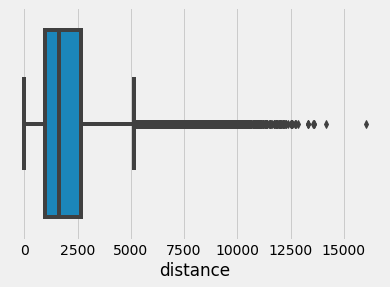

In [227]:
sns.boxplot(df_bike_data['distance'])

This looks much better now. Let's dig a little bit deeper and create a facet grid with two additional categorical dimensions gender and user type:

#### Gender

[Text(0, 0, 'Unknown'), Text(0, 0, 'Male'), Text(0, 0, 'Female')]

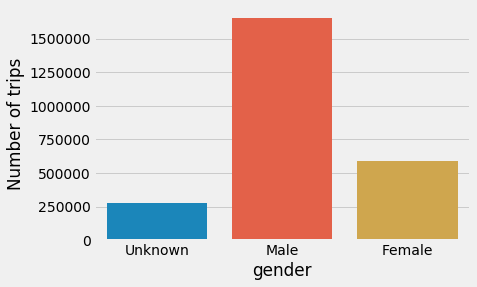

In [228]:
ax = sns.countplot(data=df_bike_data, x='gender')
ax.set_ylabel('Number of trips')
ax.set_xticklabels(['Unknown', 'Male', 'Female'])

Obviously, the service has been used overwhelmingly by men in 2019.

#### Age

Let's take a look at the recorded birth years and ages. Maybe we can find some conspicuous or even suspicious information.

Text(0.5, 1.0, 'Box plot - Age')

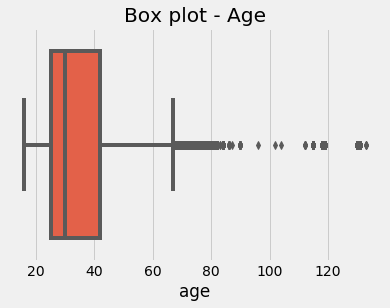

In [229]:
# univariate visualization
ax = sns.boxplot(data=df_bike_data[['usertype', 'age']], x='age', color='C1')
ax.set_title('Box plot - Age')

There seem to be massive outliers with ages far beyond 100. We assume users don't care that much about providing correct birth year information during the registration process.

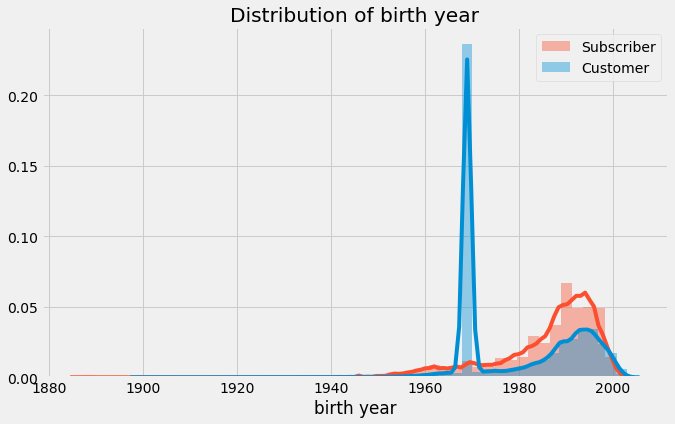

In [230]:
# univariate visualization with logarithmic scale
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plt.title = "Regplot Trip Duration"
sns.distplot(df_bike_data[df_bike_data['usertype']=='Subscriber']['birth year'], color="C1", label="Subscriber", kde=True)
sns.distplot(df_bike_data[df_bike_data['usertype']!='Subscriber']['birth year'], color="C0", label= "Customer", kde=True)
ax.set_title('Distribution of birth year')
ax.legend()

Oops! There is a huge spike in the birth year of user type Customer. We suspect there's something special to the registration process for users. For example a default birth year which many customers seem to ignore when registering or which is set if the customer doesn't provide information on his or her age at all. Let's see which specific year it is:

In [231]:
df_bike_data['birth year'].mode()

0    1969.0
dtype: float64

To mitigate the outlier problem we will add a column with age groups with 10 years interval. All users who are nominally older than 85 will be in the same group:

In [232]:
df_bike_data['agegroup'] = pd.cut(df_bike_data['age'], [15, 25, 35, 45, 55, 65, 75, 85, 160], labels=[ '15-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-85', '>85'])

Text(0.5, 1.0, 'Number of trips by age group')

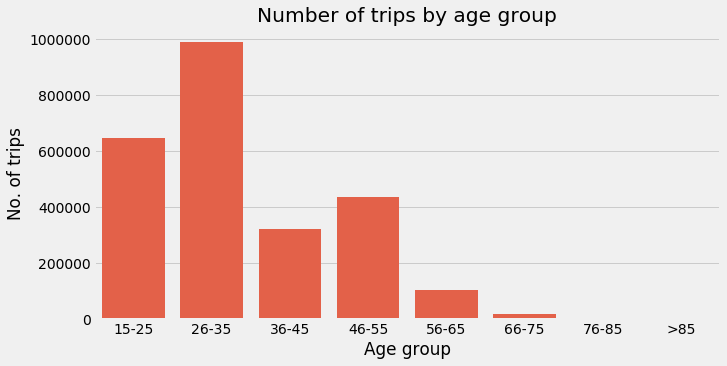

In [233]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x='agegroup', data=df_bike_data, color='C1')
ax.set_ylabel('No. of trips')
ax.set_xlabel('Age group')
ax.set_title('Number of trips by age group')

The strong presence of the age group 46-55 could be caused by the previously noticed peak of the birth year 1969, which is possibly caused by specifics of the registration process for non-subscribers. Hence, let's see what  separate countplots for usertypes look like:

Text(0.5, 1.0, 'Number of trips by age group - Subscribers/Customers')

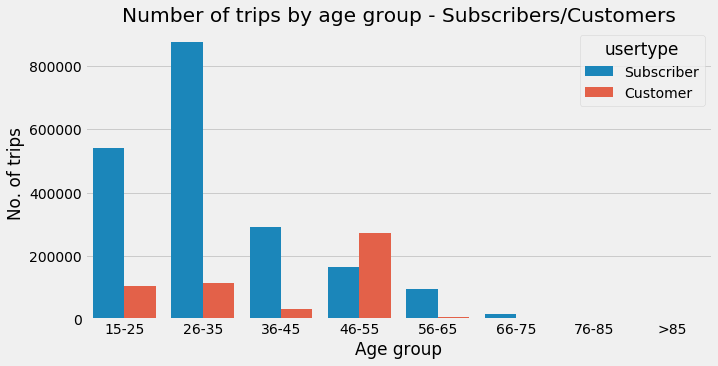

In [234]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x='agegroup', data=df_bike_data, hue='usertype')
ax.set_ylabel('No. of trips')
ax.set_xlabel('Age group')
ax.set_title('Number of trips by age group - Subscribers/Customers')

Ok, yeah. The subscriber data doesn't have the same kind of amplitude in the age group of 46 to 55. It "fits" more to what you would expect by examining the rest of the distribution. So, we have to be very careful with our interpretation of the age data in our further data analysis. In particular the customer data seems to be very flawed in this respect.

So, when including the age dimension in our analysis we will focus on the subscriber group, because their age data seems to be much more reliable.
We saw in the previous figure the the group between 26 and 35 is the most active subscriber group. Let's take a look if we can make out any differences in the trip durations of the several age groups journeys. We limit the data to tripdurations of less than 10 hours, since longer tripdurations could indicate an underlying problem with the specific record. For example a gone wrong check-out, a technical problem or similar things.

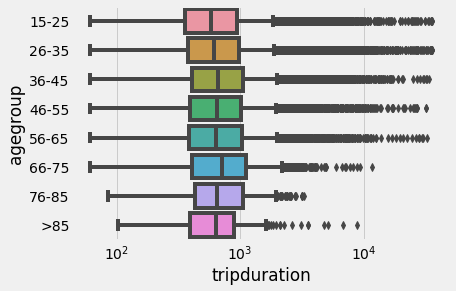

In [235]:
ax = sns.boxplot(data=df_bike_data[(df_bike_data.usertype=='Subscriber') & (df_bike_data.tripduration < 10*60*60)].sample(500000), x='tripduration', y='agegroup')
ax.set_xscale('log')

The figure appears to indicate a weak trend for longer trip durations for older riders, but we have to be careful with interpretations. Yes, young riders might be faster riders because of their physical health advantages or maybe older riders are simply using the service more for long distance trips. 

#### User types

Let's now see, if customers and subscribers are taking their rides on different days of the week:

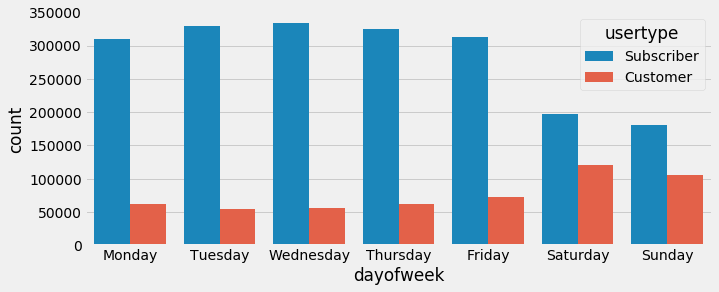

In [236]:
#sns.countplot(x='dayofweek', data=df_bike_data[df_bike_data.usertype=='Subscriber'])
plt.figure(figsize=(10,4))
ax = sns.countplot(x='dayofweek', data=df_bike_data, hue='usertype')
#plt.xticks(np.arange(0, 7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
_ = ax.set_xticklabels( ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Indeed. Subscribers can be considered far more active on weekdays than at weekends. The opposite seems to be true for *customers*.

Let's explore the distribution of trip data further and break it down to the hour level:

Text(0.5, 1.0, 'Trips at weekdays')

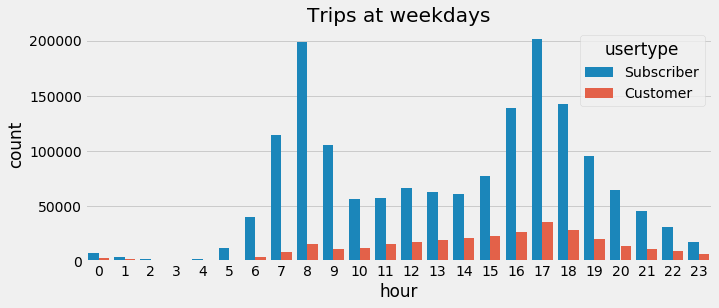

In [237]:
plt.figure(figsize=(10,4))
ax = sns.countplot(x='hour', data=df_bike_data[df_bike_data['dayofweek'] < 5], hue='usertype', palette ={"Subscriber":"C0","Customer":"C1"})
ax.set_title('Trips at weekdays')
#plt.xticks(np.arange(0, 7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
#_ = ax.set_xticklabels( ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

The figure with its peaks in the morning hours and late afternoon seems to suggest that subscribers are using the service for commuting, while non-subscribers are using the service as a pastime activity at weekends.

Text(0.5, 1.0, 'Trips at weekends')

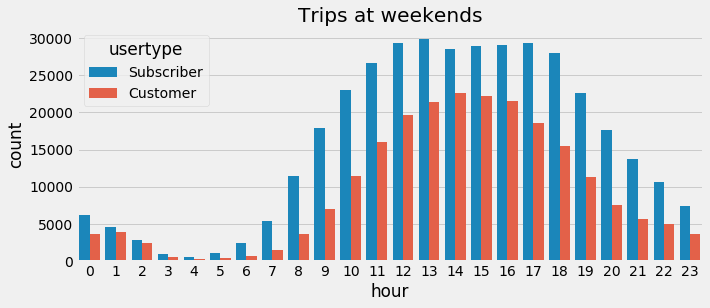

In [238]:
plt.figure(figsize=(10,4))
ax = sns.countplot(x='hour', data=df_bike_data[df_bike_data['dayofweek'] >= 5], hue='usertype', palette ={"Subscriber":"C0","Customer":"C1"})
ax.set_title('Trips at weekends')
#plt.xticks(np.arange(0, 7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
#_ = ax.set_xticklabels( ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

The figure above confirms our assumptions even more: even though strongly outnumbered in total numbers generally, the customers are catching up to the active riders from the subscriber group at weekends.

As we saw in the previous figures there is a clear 'rush hour' pattern with peaks in the morning hours and in the late afternoon on working days. Since this might be a useful and interesting feature in our further analysis, we will create an extra column with the rush hour property:

In [239]:
df_bike_data['rushhour'] = np.where((df_bike_data['dayofweek']<= 5) & (df_bike_data['hour'].isin([7,8,9,16,17,18])), True, False)
df_bike_data.head(3)

,index,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,Folder for extracting the csv files from the zip archives in the parent folder,month,date,day,week,hour,dayofweek,age,distance,agegroup,rushhour
0,0,371.0,2019-01-01 00:09:13.798,2019-01-01 00:15:25.336,80.0,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179.0,MIT Vassar St,42.355601,-71.103945,3689.0,Subscriber,1987.0,1.0,NaN,1,2019-01-01,1,1,0,1,32,1279.134116,26-35,False
1,6,304.0,2019-01-01 00:54:48.931,2019-01-01 00:59:53.581,80.0,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179.0,MIT Vassar St,42.355601,-71.103945,3861.0,Subscriber,1991.0,1.0,NaN,1,2019-01-01,1,1,0,1,28,1279.134116,26-35,False
2,1111,354.0,2019-01-01 17:54:32.797,2019-01-01 18:00:26.842,80.0,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179.0,MIT Vassar St,42.355601,-71.103945,4053.0,Subscriber,1990.0,1.0,NaN,1,2019-01-01,1,1,17,1,29,1279.134116,26-35,True


### Stations

#### Coordinates of stations

Before further exploring the station data we build an extra station data frame with a tidier form and without duplicates.

In [240]:
df_bike_data.columns

Index(['index', 'tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender',
       'Folder for extracting the csv files from the zip archives in the parent folder',
       'month', 'date', 'day', 'week', 'hour', 'dayofweek', 'age', 'distance',
       'agegroup', 'rushhour'],
      dtype='object')

In [241]:
# we extract the relevant station data for start and end stations and put them together in one data frame:
station_columns= ['stationid', 'stationname', 'lat', 'lon']
df_stations_start = df_bike_data[['start station id',
       'start station name', 'start station latitude',
       'start station longitude']].drop_duplicates()
df_stations_start.columns=station_columns
df_stations_end = df_bike_data[['end station id',
       'end station name', 'end station latitude',
       'end station longitude']].drop_duplicates()
df_stations_end.columns=station_columns
df_stations = pd.concat([df_stations_start,df_stations_end]).drop_duplicates()

Plotting the bike stations' coordinates in a scatterplot should give a picture of their geographical distribution in Boston. So let's try:

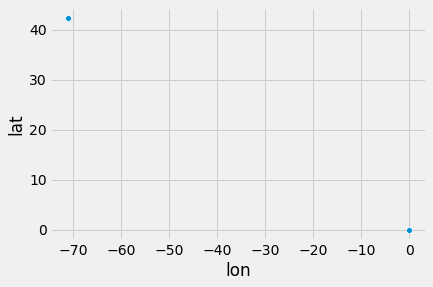

In [242]:
#df_stations = df_stations_trips[['stationid', 'stationname', 'lat', 'lon']].drop_duplicates()
sns.scatterplot(x='lon', y='lat', data=df_stations)

In [243]:
df_stations.shape

(387, 4)

Ok. Obviously there are a few outliers with incorrect spatial data (presumably 0,0) ruining the representation and we have to take care of them:

In [244]:
# looking for values 
null_stations = df_stations[df_stations['lon'] == 0]
null_stations

,stationid,stationname,lat,lon
2360711,383.0,MTL-ECO5.1-01,0.0,0.0
2444909,223.0,Warehouse Bonfire Station in a Box,0.0,0.0
1388670,230.0,8D QC Station 02,0.0,0.0
2360711,382.0,MTL-ECO4-01,0.0,0.0
2411236,164.0,Warehouse Lab PBSC,0.0,0.0


So we notice a few stations with incorrect geospatial data. We could try to get some more information from other sources to complete the geographical data, but where we go for the somewahat lazier option and consider the affected stations being invalid and drop them from our frame:

In [245]:
df_stations.isna().sum()

stationid      0
stationname    0
lat            0
lon            0
dtype: int64

In [246]:
df_stations.drop(index=null_stations.index, inplace=True)

In [247]:
df_stations.nunique()

stationid      335
stationname    351
lat            368
lon            368
dtype: int64

(-71.18919602357668, -70.88285281012625, 42.139286053099106, 42.44274111231313)

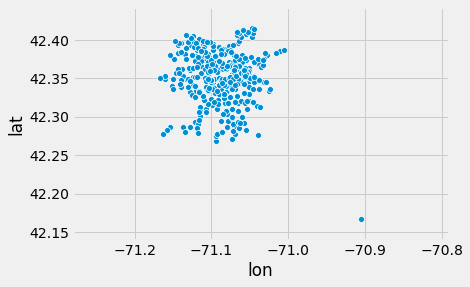

In [248]:
ax = sns.scatterplot(x='lon', y='lat', data=df_stations)
ax.axis('equal')

Hmmm. There still seems to be an outlier in relatively far distance from the city centre. We should examine this on a map.   
To this end we superimpose markers for each station on a map of boston with help of the Folium library:

In [249]:
# create map of Boston using latitude and longitude values
loc_boston = [42.25, -71.]
f = folium.Figure(width=400, height=500)
df_stats = df_stations.copy()
map_boston = folium.Map(location=[loc_boston[0], loc_boston[1]],tiles='cartodbpositron', zoom_start=10.4)

# add markers to map
for lat, lng, name in zip(df_stats['lat'], df_stats['lon'], df_stats['stationname']):
    ##label = '{}'.format(name)
    #label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=50,
        #popup=label,
        color='red',
        fill=False,
        #fill_color='#3186cc',
        #fill_opacity=0.2,
        parse_html=False).add_to(map_boston)
    
map_boston.add_to(f)



#### Popular stations
We would now like to gain insights into the most popular destinations for trips. Let's begin with the the most popular destinations overall:

In [250]:
df_end_stations_pop = df_bike_data.groupby(['end station name', 'end station id', 'end station longitude',  'end station latitude']).agg({'index':'size'}).nlargest(10,'index').reset_index()
df_end_stations_pop

,end station name,end station id,end station longitude,end station latitude,index
0,MIT at Mass Ave / Amherst St,67.0,-71.093198,42.358100,56986
1,Central Square at Mass Ave / Essex St,68.0,-71.103100,42.365070,51442
2,Ames St at Main St,107.0,-71.088220,42.362500,46295
3,Nashua Street at Red Auerbach Way,190.0,-71.064263,42.365673,46243
4,MIT Stata Center at Vassar St / Main St,80.0,-71.091156,42.362131,41828
5,South Station - 700 Atlantic Ave,22.0,-71.055547,42.352175,40861
6,Harvard Square at Mass Ave/ Dunster,74.0,-71.118579,42.373268,35990
7,MIT Pacific St at Purrington St,178.0,-71.101295,42.359573,32914
8,Kendall T,189.0,-71.084955,42.362428,32389
9,MIT Vassar St,179.0,-71.103945,42.355601,28517


In [251]:
# create map of Boston using latitude and longitude values
loc_boston = [42.35, -71.08]
f = folium.Figure(width=500, height=500)
map_boston = folium.Map(location=[loc_boston[0], loc_boston[1]],tiles='cartodbpositron', zoom_start=13)

# add markers to map
for lat, lng, name in zip(df_end_stations_pop['end station latitude'], df_end_stations_pop['end station longitude'], df_end_stations_pop['end station name']):
    ##label = '{}'.format(name)
    label = folium.Popup(name, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=50,
        popup=label,
        color='red',
        fill=False,
        #fill_color='#3186cc',
        #fill_opacity=0.2,
        parse_html=False).add_to(map_boston)
    
map_boston.add_to(f)



As we might have expected, the the ten most popular end stations include crucial locations for public transport, e.g. North Station (Nashua Street) and South station, as well as several stations in proximity of the famous educational institutions Havard University and MIT. 

Let's now explore the distribution of rides ending at the top 10 destination locations by hour of day:

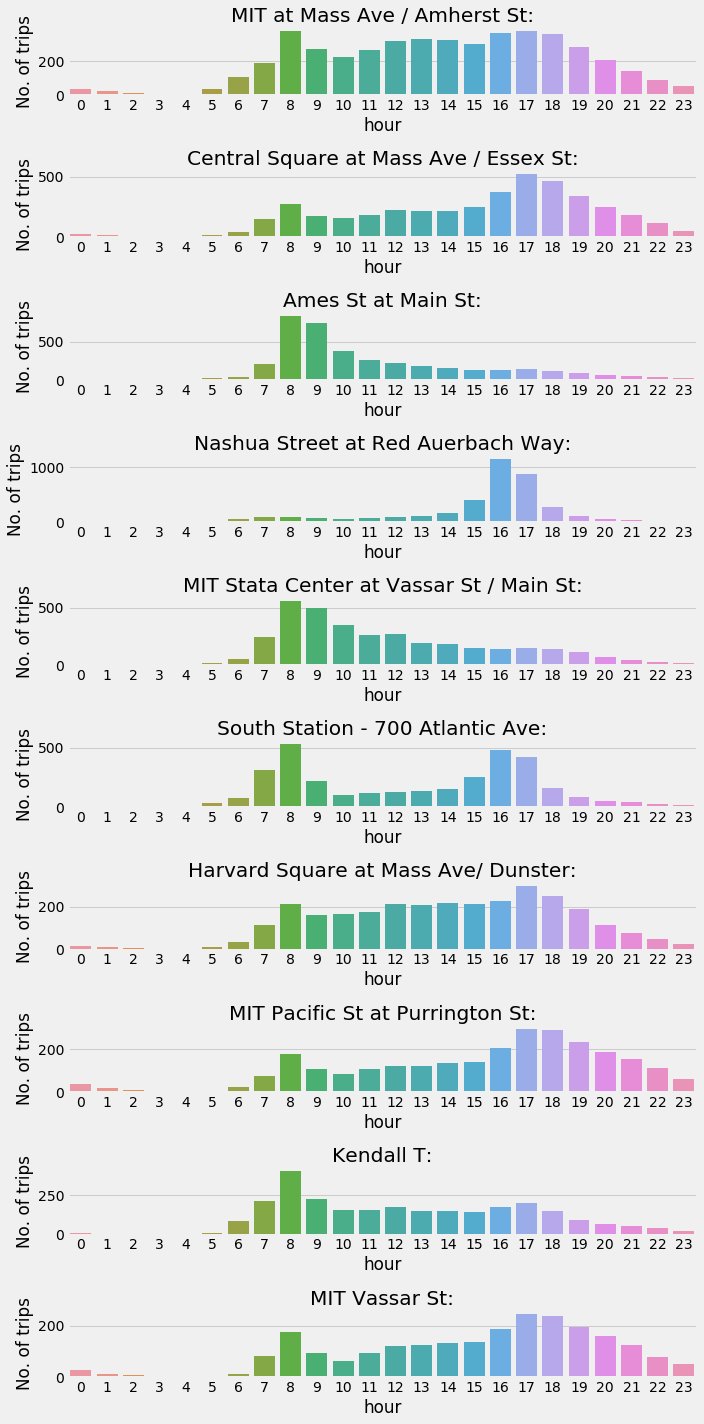

In [254]:
df = df_bike_data[df_bike_data['end station id'].isin(df_end_stations_pop['end station id'].values)].groupby(['hour', 'end station name', 'end station id','month']).agg({'index':'size'}).reset_index()
fig, ax = plt.subplots(10,1, figsize=(10,20))
for i, s_id in enumerate(zip(df_end_stations_pop['end station id'], df_end_stations_pop[ 'end station name'].values), 1):
    #print(s_id[1])
    plt.subplot(10,1,i)
    ax = sns.barplot(data=df[df['end station id']==s_id[0]], y='index', x='hour', label='end station name', ci=None)
    ax.set_title(s_id[1] + ":")
    ax.set_ylabel('No. of trips')

fig.tight_layout()
#fig.suptitle('End station by hour')
#fig.savefig('img/top10stations.png')

This is very interesting! Some of the stations show striking unimodal peaks during specific daytimes while other have a more bimodal or more even distribution. 

In [255]:
df_start_stations = df_bike_data.groupby(['start station name', 'start station id', 'start station longitude',  'start station latitude']).agg({'index':'size'}).reset_index()
df_start_stations

,start station name,start station id,start station longitude,start station latitude,index
0,175 N Harvard St,149.0,-71.129164,42.363796,11384
1,18 Dorrance Warehouse,1.0,-71.075978,42.387151,498
2,191 Beacon St,378.0,-71.108786,42.380323,5941
3,30 Dane St,330.0,-71.104025,42.381001,9220
4,30 Dane St.,330.0,-71.104025,42.381001,308
...,...,...,...,...,...
379,Western Ave at Richardson St,428.0,-71.143931,42.361787,856
380,Whittier St Health Center,443.0,-71.092189,42.332863,202
381,Williams St at Washington St,279.0,-71.107669,42.306539,2344
382,Wilson Square,99.0,-71.114121,42.385676,538


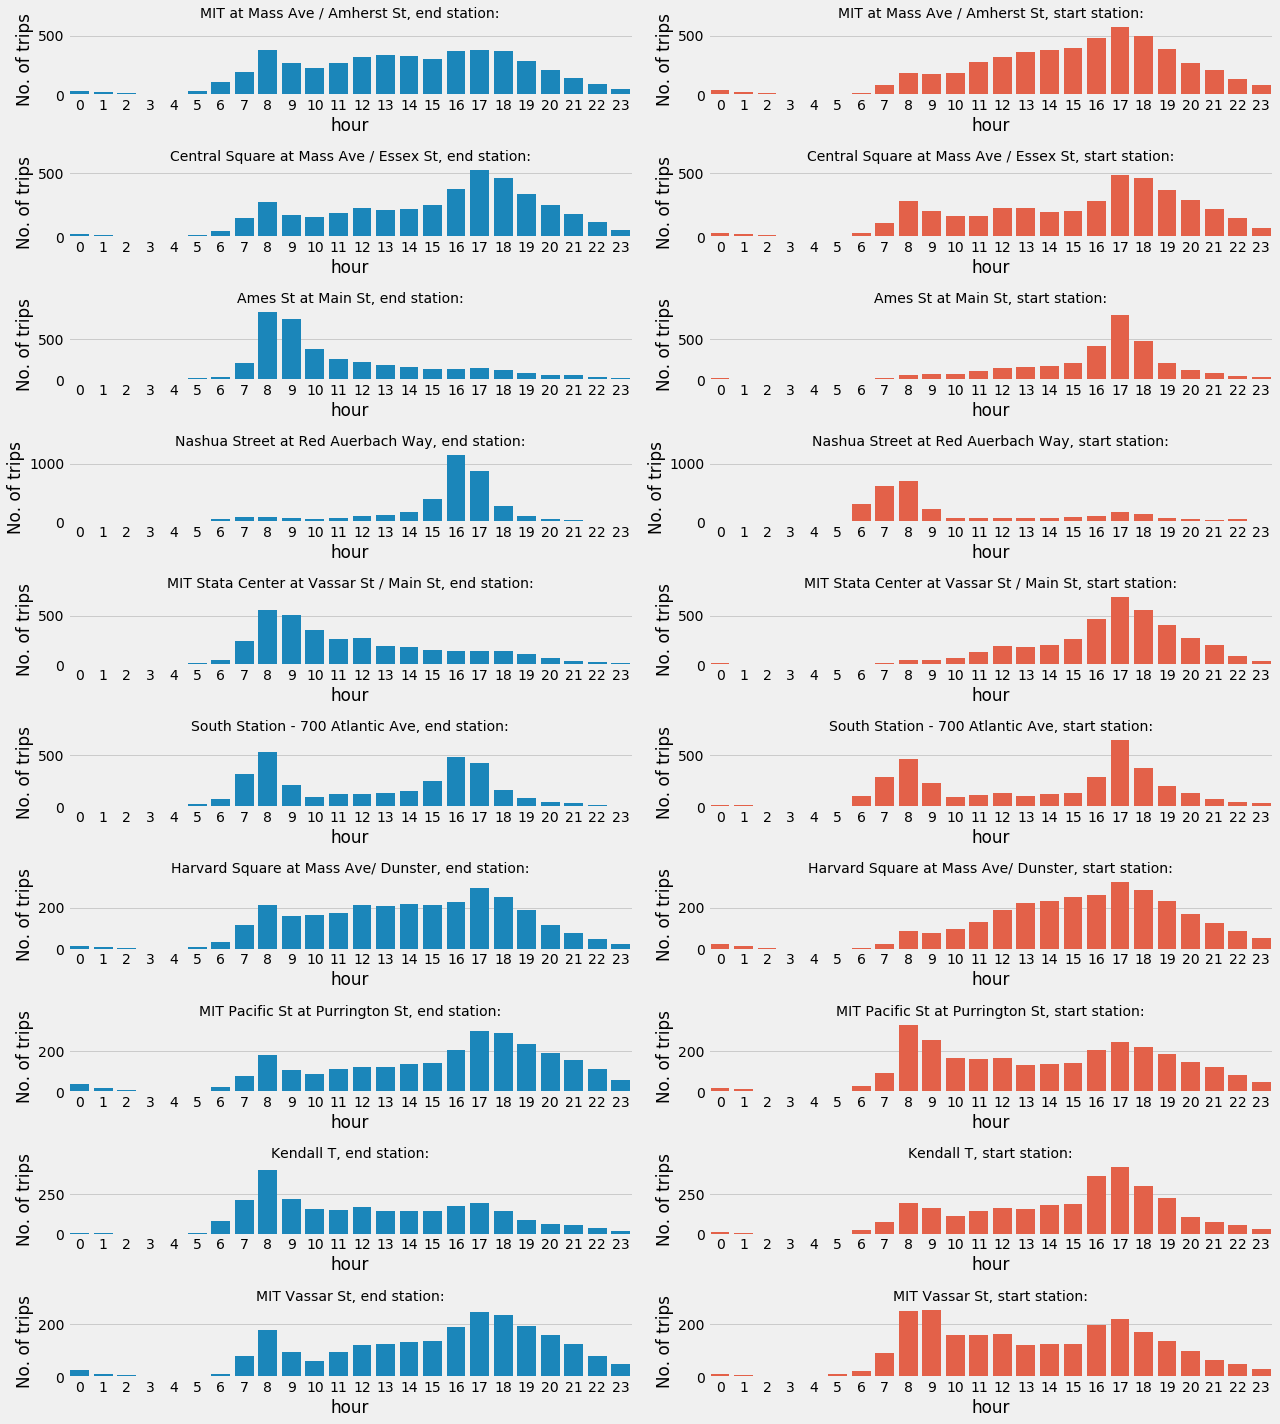

In [257]:
df_end = df_bike_data[df_bike_data['end station id'].isin(df_end_stations_pop['end station id'].values)].groupby(['hour', 'end station name', 'end station id', 'month']).agg({'index':'size'}).reset_index()
df_start = df_bike_data[df_bike_data['start station id'].isin(df_end_stations_pop['end station id'].values)].groupby(['hour', 'start station name', 'start station id', 'month']).agg({'index':'size'}).reset_index()
 
fig, ax = plt.subplots(10,2, figsize=(18,20), sharey='row')
for i, s_id in enumerate(zip(df_end_stations_pop['end station id'], df_end_stations_pop[ 'end station name'].values), 1):
    #print(s_id[1])
    plt.subplot(10,2,(i-1)*2 + 1)
    ax1 = sns.barplot(data=df_end[df_end['end station id']==s_id[0]], y='index', x='hour', label='end station name', ci=None, color="C0")
    ax1.set_title(s_id[1] + ", end station:", fontsize=14)
    ax1.set_ylabel('No. of trips')
    plt.subplot(10,2,(i*2), sharey=ax1)
    ax2 = sns.barplot(data=df_start[df_start['start station id']==s_id[0]], y='index', x='hour', label='start station name', ci=None, color="C1")
    ax2.set_title(s_id[1] + ", start station:", fontsize=14)
    ax2.set_ylabel('No. of trips')
    

fig.tight_layout()
#fig.suptitle('End station by hour')
#fig.savefig('img/top10stations.png')

The previous figure shows the usage of the 10 most popular destination station over the course of the day and shows some interesting patterns when
adding the usage as start station as well. Some of the stations show striking unimodal peaks during specific daytimes while other have a more bimodal or more even distribution. 
Along with the data for usage as start stations we can often make out corresponding peaks for locations like Ames Street, a main destination in the morning hours and a popular start location in the afternoon, or Nashua Street, a main destination in the after noon and frequently used as start station in the morning. The latter bike station is next to Boston's North station, a crucial node in Boston's public transport system. South Station, another important junction, is showing bimodal distributions indicating arrivals and departures of commuters in the morning as well as in the afternoon.

### Routes

To investigate the most popular routes let's first create a new helper column "route" which combines the start and the end station:

In [259]:
df_bike_data['route'] = df_bike_data['start station id'].astype(str) + ',' + df_bike_data['end station id'].astype(str)
df_bike_data.head(3)

,index,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,Folder for extracting the csv files from the zip archives in the parent folder,month,date,day,week,hour,dayofweek,age,distance,agegroup,rushhour,route
0,0,371.0,2019-01-01 00:09:13.798,2019-01-01 00:15:25.336,80.0,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179.0,MIT Vassar St,42.355601,-71.103945,3689.0,Subscriber,1987.0,1.0,NaN,1,2019-01-01,1,1,0,1,32,1279.134116,26-35,False,"80.0,179.0"
1,6,304.0,2019-01-01 00:54:48.931,2019-01-01 00:59:53.581,80.0,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179.0,MIT Vassar St,42.355601,-71.103945,3861.0,Subscriber,1991.0,1.0,NaN,1,2019-01-01,1,1,0,1,28,1279.134116,26-35,False,"80.0,179.0"
2,1111,354.0,2019-01-01 17:54:32.797,2019-01-01 18:00:26.842,80.0,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179.0,MIT Vassar St,42.355601,-71.103945,4053.0,Subscriber,1990.0,1.0,NaN,1,2019-01-01,1,1,17,1,29,1279.134116,26-35,True,"80.0,179.0"


Then we calculate the most popular routes and store the results in a new data frame name `df_pop_routes`:

In [260]:
top_n = 40
df_pop_routes = df_bike_data.groupby(['route','start station latitude', 'start station longitude' , 'end station latitude' , 'end station longitude' ]).size().reset_index().rename(columns={0:'cnt'}).nlargest(top_n, 'cnt')
df_pop_routes

,route,start station latitude,start station longitude,end station latitude,end station longitude,cnt
16296,"178.0,80.0",42.359573,-71.101295,42.362131,-71.091156,4956
61974,"80.0,178.0",42.362131,-71.091156,42.359573,-71.101295,4899
57661,"67.0,179.0",42.358100,-71.093198,42.355601,-71.103945,4411
57828,"67.0,53.0",42.358100,-71.093198,42.350827,-71.089811,4187
16061,"178.0,107.0",42.359573,-71.101295,42.362500,-71.088220,4097
57961,"68.0,178.0",42.365070,-71.103100,42.359573,-71.101295,3986
53849,"53.0,67.0",42.350827,-71.089811,42.358100,-71.093198,3933
16551,"179.0,80.0",42.355601,-71.103945,42.362131,-71.091156,3887
16324,"179.0,107.0",42.355601,-71.103945,42.362500,-71.088220,3855
26471,"239.0,328.0",42.394072,-71.111337,42.396387,-71.120113,3830


Let's then plot the most popular routes as coloured lines into a scatterplot of all the stations:

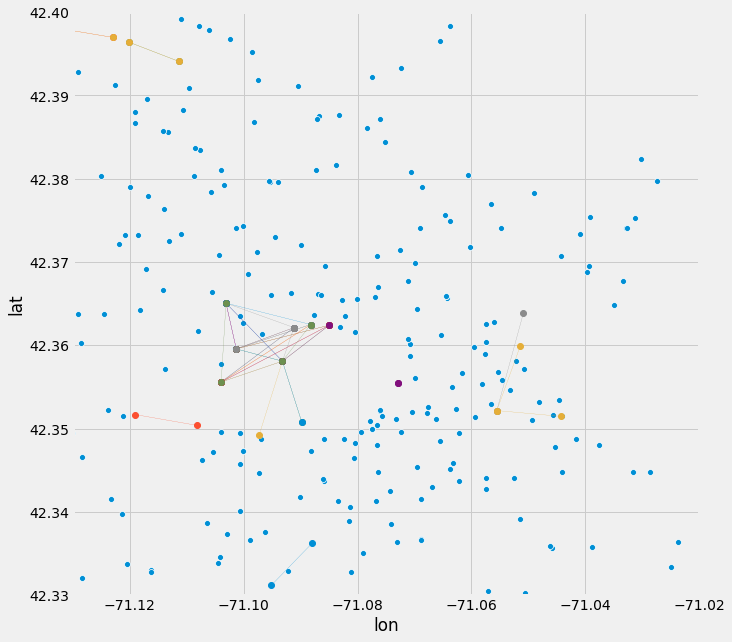

In [261]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_xlim(-71.13, -71.02)
ax.set_ylim(42.33, 42.40)
ax = sns.scatterplot(x='lon', y='lat', data=df_stations)
#plt.scatter(x=points[:,1],y=points[:,0])
#plt.scatter(x=points[:,3],y=points[:,2]+0.001)
for i in range(df_pop_routes.shape[0]):
    plt.plot(df_pop_routes.iloc[i, 2:5:2].values,df_pop_routes.iloc[i, 1:4:2].values, marker='o', lw=0.2)

This seems a little bit messy. Let's superimpose the routes onto a folium map:

In [262]:
# create map of Boston using latitude and longitude values
loc_boston = [42.35, -71.1]
f = folium.Figure(width=600, height=500)
df_stats = df_stations.copy()
map_boston = folium.Map(location=[loc_boston[0], loc_boston[1]],tiles='cartodbpositron', zoom_start=12.2)
for index, row in df_pop_routes.iterrows():
    p1= row['start station latitude'], row['start station longitude']
    p2 = row['end station latitude'], row['end station longitude']
    folium.PolyLine(locations=[p1, p2], color='#3388ff', weight=1).add_to(map_boston)
    folium.Circle(
        p1,
        radius=50,
        #popup=label,
        color='#3186cc',
        fill=True,
        fill_color='#3186cc',
        #fill_opacity=0.2,
        parse_html=False).add_to(map_boston)
    folium.Circle(
        p2,
        radius=50,
        #popup=label,
        color='#3186cc',
        fill=True,
        fill_color='#3186cc',
        #fill_opacity=0.2,
        parse_html=False).add_to(map_boston)

    
    
map_boston.add_to(f)


### Trip purposes:
I am now interested to find the trips which are mainly used for recreational purposes. The strategy to find these trips is as follows: assuming that a recreational trip in many cases returns to the starting point we will filter down to trips with the same start and end point. We also assume that a recreational trip will last at least 45 minutes.

In [263]:
df_bike_data['purpose'] = np.where((df_bike_data.distance < 100 ) & (df_bike_data.tripduration > 30*60), 'Recreational', 'Unknown')

a simple test whether this strategy was successful might be to check if most of the trips are at the weekend rather than on working days:

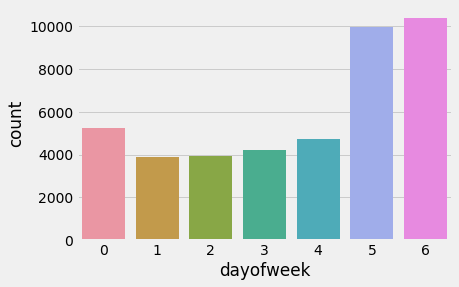

In [264]:
sns.countplot(data=df_bike_data[df_bike_data.purpose=='Recreational'], x='dayofweek')

Also, we might expect a relatively high fraction of user type "Customer" taking these trips:

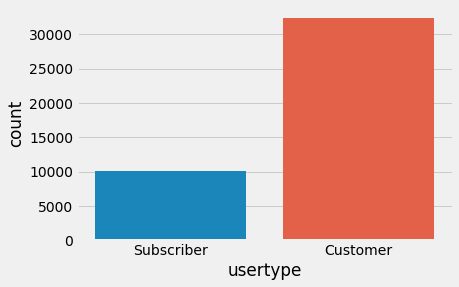

In [265]:
sns.countplot(data=df_bike_data[df_bike_data.purpose=='Recreational'], x='usertype')

### 2. Weather data

We want to keep only the columns with max temperature, precipitation and date. So:

In [266]:
columns_to_keep = ['DATE', 'PRCP', 'TMAX']
df_weather_clean = df_weather[columns_to_keep].copy()
df_weather_clean.head()

,DATE,PRCP,TMAX
0,2019-01-01,9.7,15.0
1,2019-01-02,0.0,2.8
2,2019-01-03,0.5,7.8
3,2019-01-04,0.0,8.9
4,2019-01-05,13.5,6.1


`DATE`is still in string format. We have to convert it to datetime:

In [267]:
df_weather_clean['DATE'] = pd.to_datetime(df_weather_clean['DATE'])
df_weather_clean.dtypes

DATE    datetime64[ns]
PRCP           float64
TMAX           float64
dtype: object

In [268]:
df_weather_clean.dtypes
df_weather_clean = df_weather_clean.set_index('DATE')


In [269]:
df_weather_clean.resample('M')

Let's take a look at the temperature profile of the data:

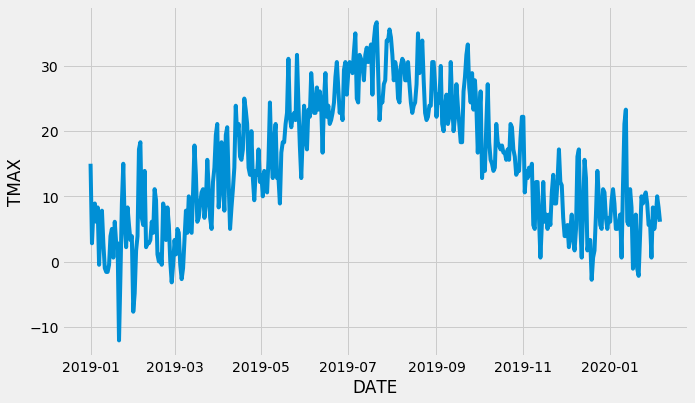

In [270]:
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x=df_weather_clean.index, y='TMAX', data=df_weather_clean)


And another visualization with a heatmap:

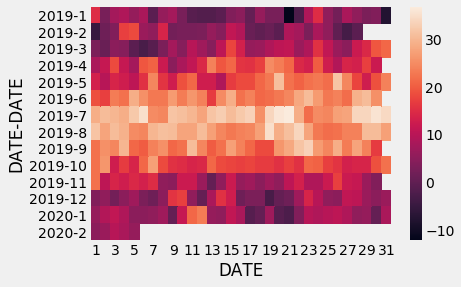

In [271]:
sns.heatmap(df_weather_clean.pivot_table(index=[df_weather_clean.index.year,df_weather_clean.index.month], columns=df_weather_clean.index.day, values = 'TMAX'))

In [272]:
df_weather_clean

,PRCP,TMAX
DATE,,
2019-01-01,9.7,15.0
2019-01-02,0.0,2.8
2019-01-03,0.5,7.8
2019-01-04,0.0,8.9
2019-01-05,13.5,6.1
...,...,...
2020-02-01,0.5,5.0
2020-02-02,0.0,6.7
2020-02-03,0.0,10.0


### Bringing it all together. Join Weather data and Trip data.

In [198]:
df_clean = pd.merge(df_bike_data, df_weather_clean, left_on='date', right_on='DATE')

df_clean.head()

,index,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,month,date,day,week,hour,dayofweek,age,distance,agegroup,rushhour,route,purpose,PRCP,TMAX
0,0,371,2019-01-01 00:09:13.798,2019-01-01 00:15:25.336,80,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179,MIT Vassar St,42.355601,-71.103945,3689,Subscriber,1987,1,1,2019-01-01,1,1,0,1,32,1279.134116,26-35,False,"80,179",Unknown,9.7,15.0
1,6,304,2019-01-01 00:54:48.931,2019-01-01 00:59:53.581,80,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179,MIT Vassar St,42.355601,-71.103945,3861,Subscriber,1991,1,1,2019-01-01,1,1,0,1,28,1279.134116,26-35,False,"80,179",Unknown,9.7,15.0
2,1111,354,2019-01-01 17:54:32.797,2019-01-01 18:00:26.842,80,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179,MIT Vassar St,42.355601,-71.103945,4053,Subscriber,1990,1,1,2019-01-01,1,1,17,1,29,1279.134116,26-35,True,"80,179",Unknown,9.7,15.0
3,1114,397,2019-01-01 17:57:05.568,2019-01-01 18:03:43.000,80,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179,MIT Vassar St,42.355601,-71.103945,4160,Subscriber,1987,1,1,2019-01-01,1,1,17,1,32,1279.134116,26-35,True,"80,179",Unknown,9.7,15.0
4,1140,320,2019-01-01 18:33:41.350,2019-01-01 18:39:01.927,80,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179,MIT Vassar St,42.355601,-71.103945,2893,Subscriber,1985,1,1,2019-01-01,1,1,18,1,34,1279.134116,26-35,True,"80,179",Unknown,9.7,15.0


save the data before we continue. This file is used for the explanatory slide deck notebook.

In [273]:
df_clean.to_csv('./data/clean_data.csv')

4
5
6
7
8
9
10


Text(0.5, 0.98, 'Precipitation and usage - April to October')

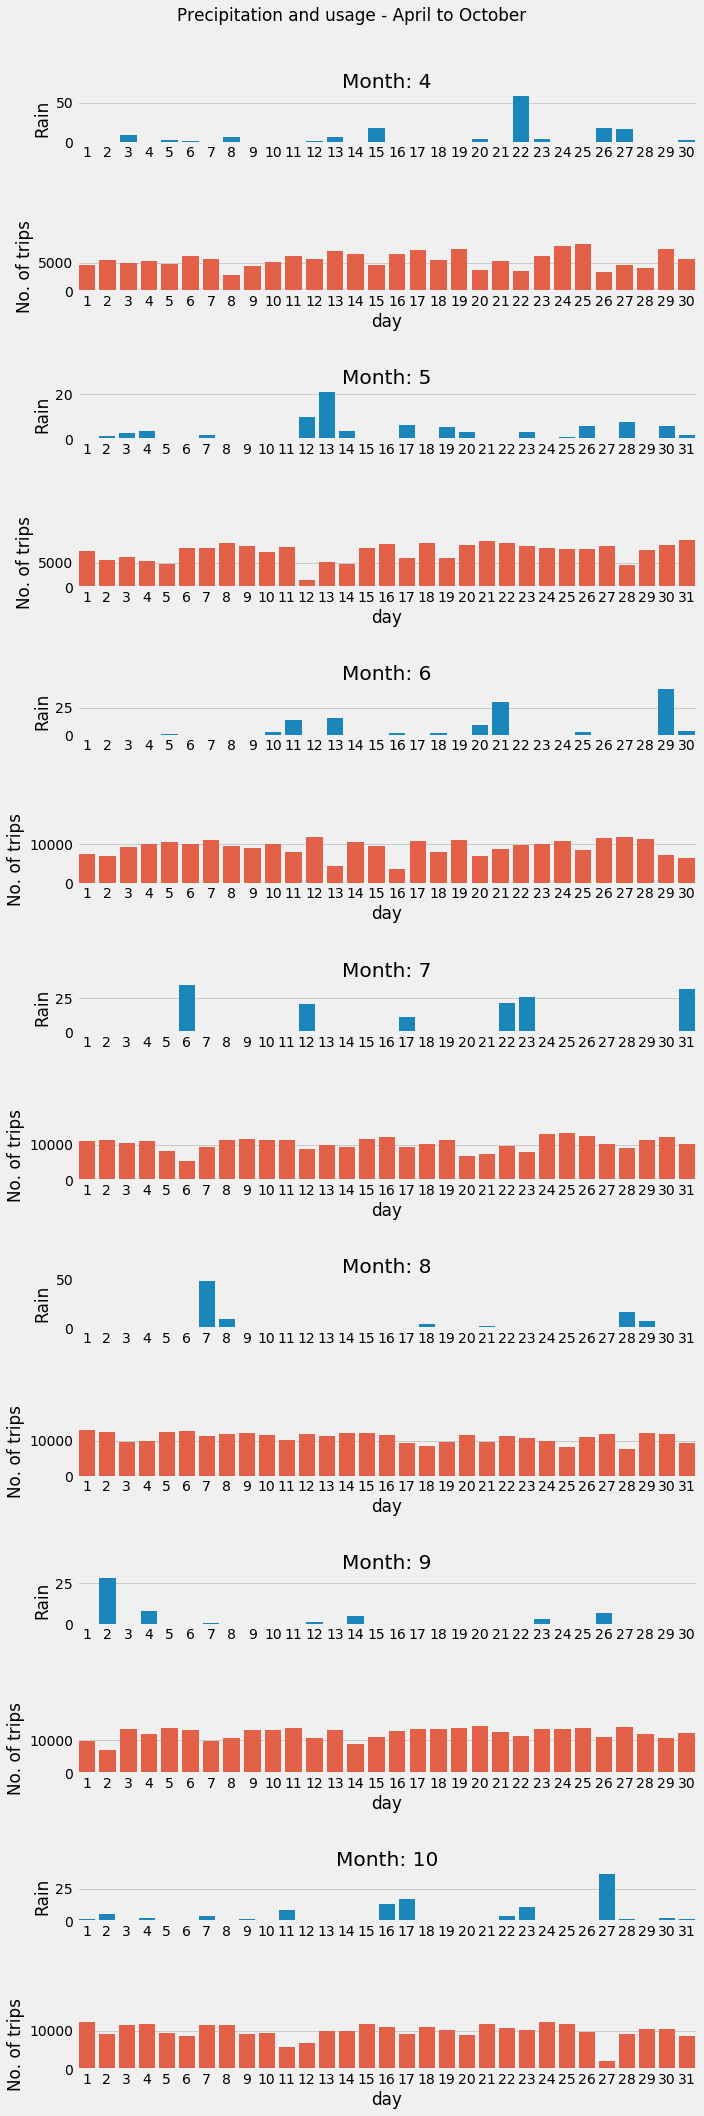

In [197]:
df_rain_days =df_clean[df_clean.month.isin([4, 5, 6, 7, 8, 9, 10])].groupby(['day','month']).agg({'PRCP':'first','index':'size'}).reset_index()
df_rain_days
fig , ax = plt.subplots(14,1,figsize=(10, 30))
for i, m in enumerate(range(4, 11), 1):
    plt.subplot(14, 1, (i-1)*2 + 1)
    #print(m)
    ax1 = sns.barplot(data=df_rain_days[df_rain_days.month==m], x='day', y='PRCP', color='C0')
    ax1.set_title('Month: {}'.format(m))
    ax1.set_xlabel("")
    ax1.set_ylabel('Rain')
    plt.subplot(14, 1, (i * 2))
    ax2 = sns.barplot(data=df_rain_days[df_rain_days.month==m], x='day', y='index', color='C1')
    ax2.set_ylabel('No. of trips')
plt.tight_layout()
plt.subplots_adjust(hspace=2, top=0.94)
plt.suptitle("Precipitation and usage - April to October")
    #ax2.set_xticks([])

The expectation is that users should be more reluctant to use the bike sharing service when it's rainy outside.
The previous figures show the amount of precipitation for the months from April to October and the corresponding
usage of the Bluebikes service beneath. We expect to notice a drop of usage when there was a lot of rain the same
day. And indeed we are able to observe these relationships in a lot of cases. Example dates are: 04/26, 04/27, 05/12 or 10/27. We assume nightly rainfall when
we don't observe an obvious link between the usage rate and high precipitation numbers.

Let's now take a look on a link that should be straightforward: we expect higher usage rates when the outdoor temperatures are higher.

Text(0.5, 1.0, 'Daily trips by Temperature')

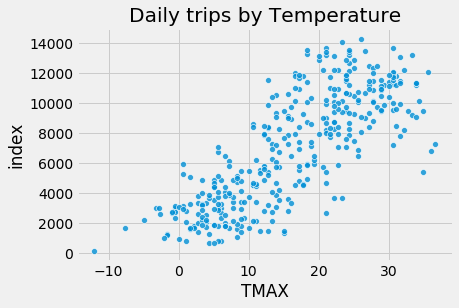

In [274]:
df_group_temp = df_clean.groupby(['date', 'TMAX']).agg({'index':'count'}).reset_index()
ax = sns.scatterplot(data=df_group_temp, x='TMAX', y='index',alpha=0.8)
ax.set_title('Daily trips by Temperature')


Ok, that's not surprising. Of course there is a strong correlation between the temperature and the number of trips. Let's dig a bit deeper and see if this correlation is valid for all age groups and males and females equally.

In [275]:
df_group = df_clean[(df_clean.usertype=='Subscriber') & (df_clean.gender.isin([1, 2]))].groupby(['date','TMAX','agegroup','gender', 'month'], observed=True).agg({'index':'count'}).reset_index()
df_group

,date,TMAX,agegroup,gender,month,index
0,2019-01-01,15.0,15-25,1,1,131
1,2019-01-01,15.0,15-25,2,1,27
2,2019-01-01,15.0,26-35,1,1,361
3,2019-01-01,15.0,26-35,2,1,131
4,2019-01-01,15.0,36-45,1,1,76
...,...,...,...,...,...,...
5015,2019-12-31,6.7,56-65,1,12,85
5016,2019-12-31,6.7,56-65,2,12,42
5017,2019-12-31,6.7,66-75,1,12,30
5018,2019-12-31,6.7,66-75,2,12,1


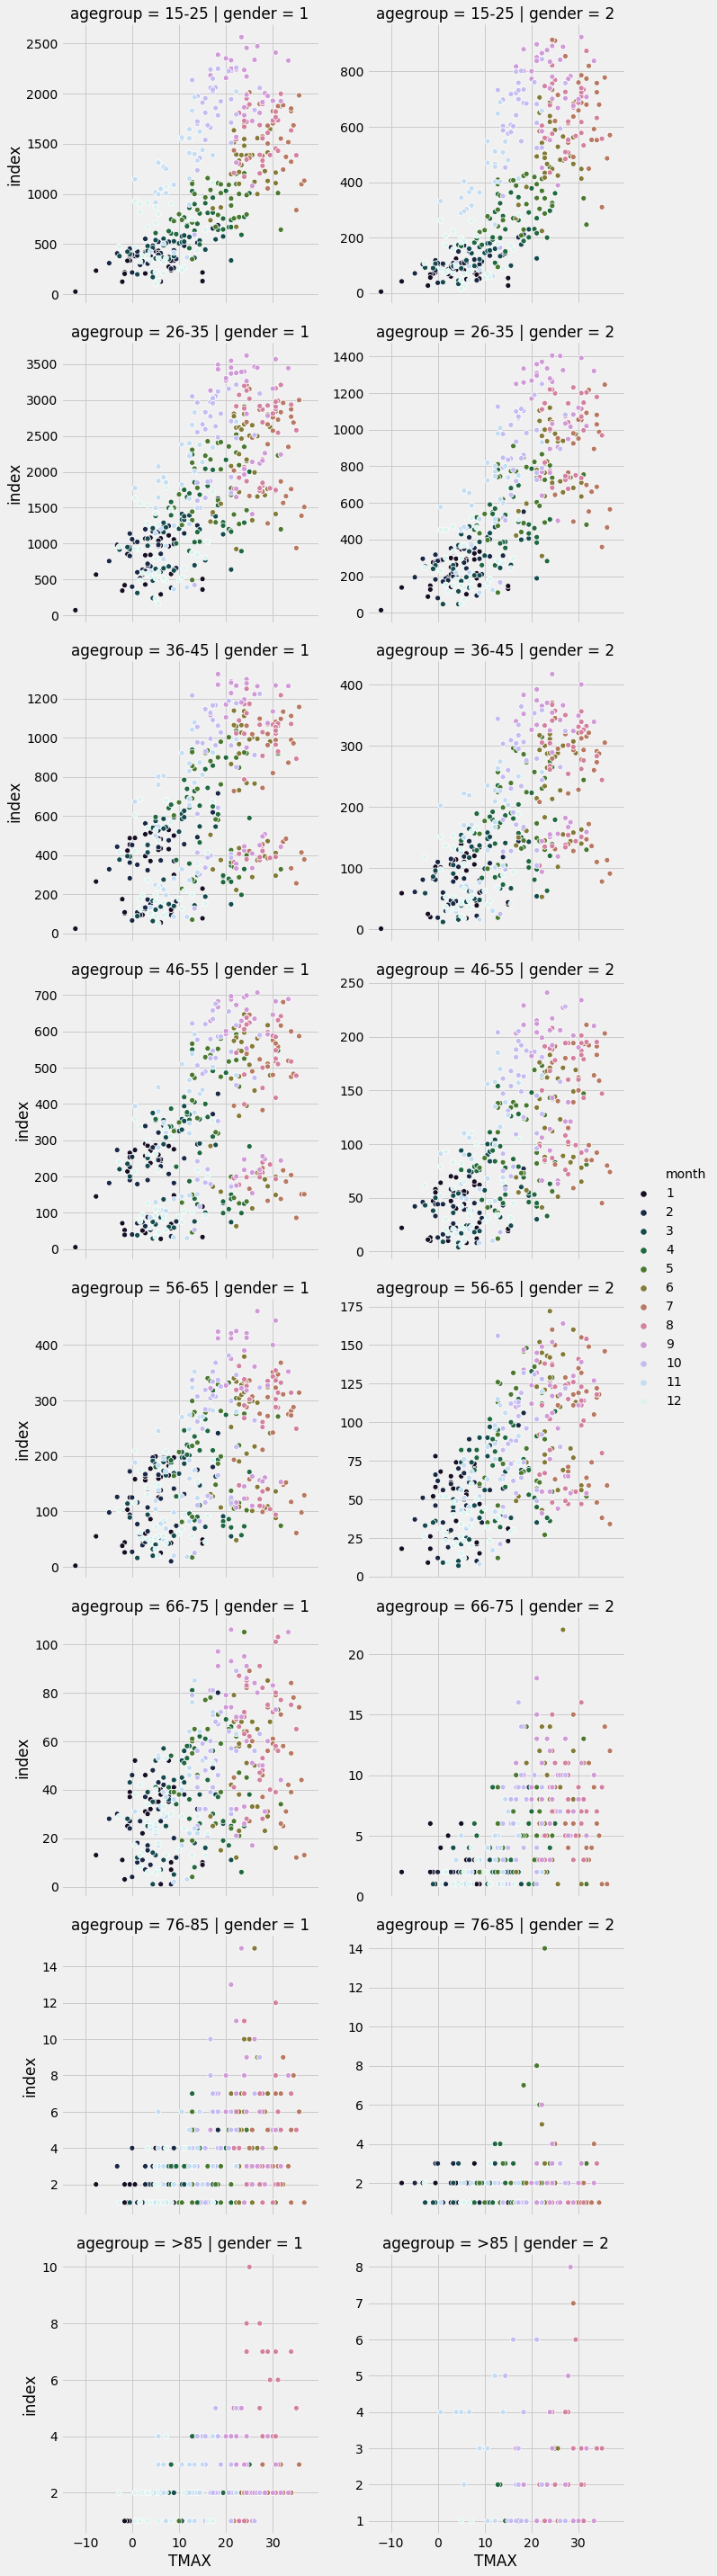

In [276]:
sns.relplot(data=df_group, x='TMAX', y='index', row='agegroup', col='gender', palette=sns.color_palette("cubehelix", n_colors=12),  hue='month', facet_kws={'sharey': False, 'sharex': True})